<a href="https://colab.research.google.com/github/tishakbhavsar/practising-pytorch/blob/main/04_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Custom Datasets in Pytorch :D

We've used some datasets with PyTorch before. But how do you get your own data in PyTorch?

Domain libraries : Depending upon what you are working on, vision, text, audio, recommendation-> there torch libraries for each.

### 0.1 Importing PyTorch, Setting up device agnostic code

In [299]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu124'

In [300]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 0.2 Working with Food-101 Data Set - Smaller Version


Our data is a subset of the larger data. Only three classes of food and only 10 % of the images (~75 training, ~25 testing). Starting small and humble :)

In [301]:
import requests
import zipfile
from pathlib import Path

# Set up path to a data folder
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
  print(f'Image path exists. Skipping download!')
else:
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
  print("Downloading data...")
  f.write(request.content)

# Unzip the zip file
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

# Remove zip file
import os
os.remove(data_path/"pizza_steak_sushi.zip")


Image path exists. Skipping download!
Unzipping pizza, steak and sushi data...


### Observing the data

In [302]:
import os
def walk_through_dr(dir_path):
  """ Walks through dir_path, returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} in '{dirpath}")

walk_through_dr(image_path)

There are 2 directories and 0 in 'data/pizza_steak_sushi
There are 3 directories and 0 in 'data/pizza_steak_sushi/train
There are 0 directories and 75 in 'data/pizza_steak_sushi/train/steak
There are 0 directories and 72 in 'data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 in 'data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 in 'data/pizza_steak_sushi/test
There are 0 directories and 19 in 'data/pizza_steak_sushi/test/steak
There are 0 directories and 31 in 'data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 in 'data/pizza_steak_sushi/test/pizza


#### Our labels are our folder names for example : pizza, steak and sushi are folder names

In [303]:
# Setup train and testing paths

train_dir = image_path/"train"
test_dir = image_path/"test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualising data

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python PIL
5. Show image metadata.

data/pizza_steak_sushi/train/pizza/2760984.jpg
pizza
Random image path: data/pizza_steak_sushi/train/pizza/2760984.jpg
Image class: pizza
Image height: 512
Image width: 512


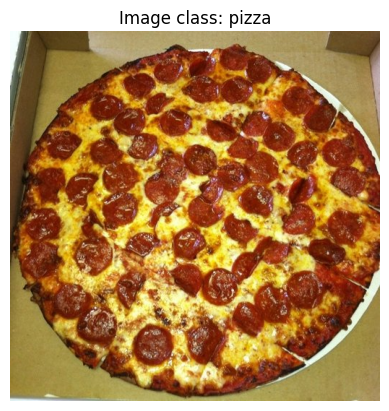

In [304]:
import random
from PIL import Image
import matplotlib.pyplot as plt
# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # we want all image paths (train-test/pizza-steak-sushi/image name)


# 2. Pick random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class (the image class is the name of the direc where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
plt.imshow(img)
plt.title(f'Image class: {image_class}')
plt.axis(False);

#### Visualizing with matplotlib!

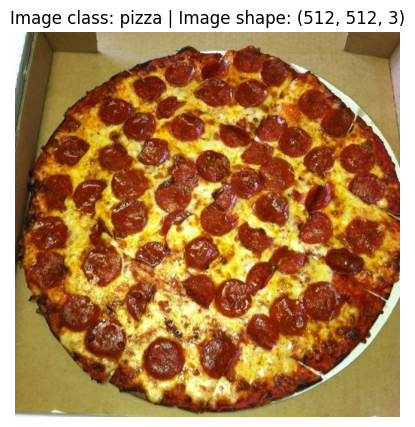

In [305]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape}')
plt.axis(False);

### 3. Transforming data

Before we can use our image data with PyTorch, we need to:

1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Dataset`
3. Turn datasets into a `torch.utils.data.DataLoader`

In [306]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [307]:
# Write a transform for image

# to combine transforms we can use nn.Sequential or transfroms.Compose!
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Another transform to flip images - data augmentation - increasing diversity of the data
    transforms.RandomHorizontalFlip(p=0.5), # 50 % of the time, gets flipped
    transforms.ToTensor() # convert numpy array or PIL image to a tensor
])

In [308]:
transformed_image = data_transform(img) # did not work for data_transform(img_as_array)

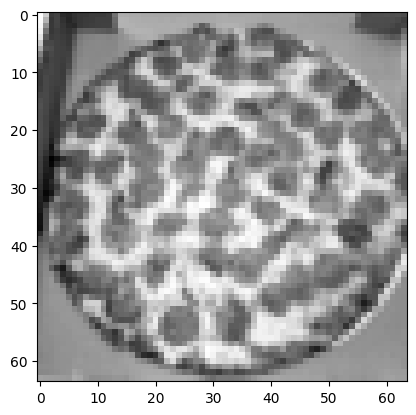

In [309]:
one_channel = transformed_image[0]
plt.imshow(one_channel, cmap="gray")

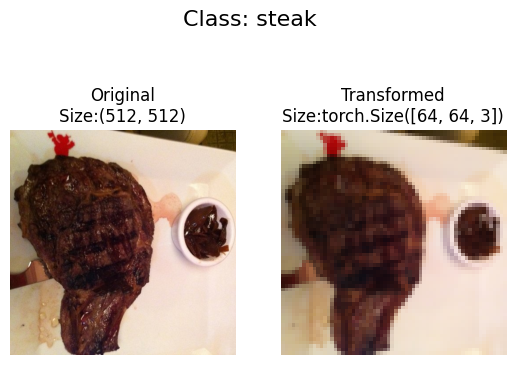

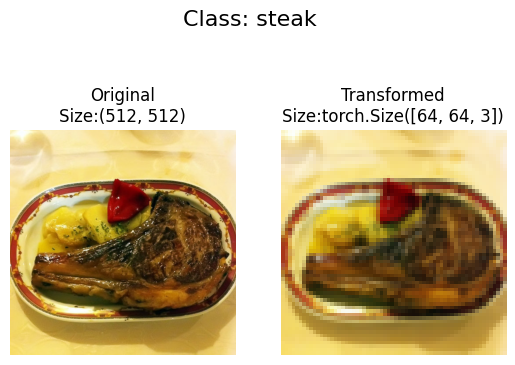

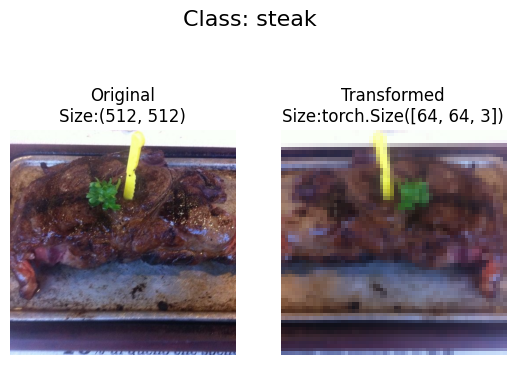

In [310]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """ Selects n random images from a path of images, transforms them
  with transform and plots them side by side with the original images.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig,ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize:{f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      # going from C H W to H W C because matplotlib supports H W C
      transformed_image = transform(f).permute(1,2,0) # note we will need to change shape for maptlotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nSize:{transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform = data_transform,
                        n = 3)

#### Doing it for all images

### Option 1: Loading data using ImageFolder

We can load image classification data using torchvision.datasets.ImageFolder


In [311]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform = data_transform,
                                  target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [312]:
# Get class names as a list
print(f"Class names: {train_data.classes}")
print(f"Class names as a dictionary: {train_data.class_to_idx}")

Class names: ['pizza', 'steak', 'sushi']
Class names as a dictionary: {'pizza': 0, 'steak': 1, 'sushi': 2}


In [313]:
# Check the lengths of datasets
len(train_data), len(test_data)

(225, 75)

In [314]:
train_data[0][0], train_data[0][1] # image, label

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [315]:
print(f"Image shape: {train_data[0][0].shape}")
print(f"Label: {train_data[0][1]}")
class_names = train_data.classes

Image shape: torch.Size([3, 64, 64])
Label: 0


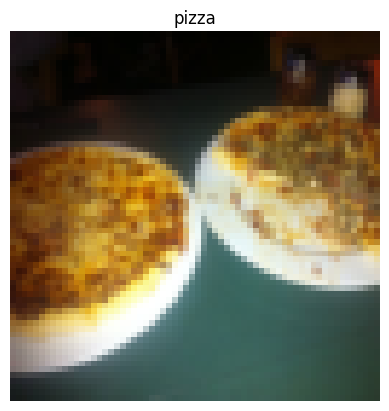

In [316]:
# Index on train_data Dataset to get a single image
image, label = train_data[0]
plt.imshow(image.permute(1,2,0)) # re arrange order of dimensions
plt.title(class_names[label])
plt.axis(False);

### Turn loaded images into DataLoaders

In [317]:
import os
os.cpu_count() # how many cpu cores -> shows google colab ones here -> 2

2

In [318]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1 # change to 32 later
#num_workers = 1 # how many CPU cores are working together to load your data?

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)


test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers = 1,
                              shuffle=False)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [319]:
img, label = next(iter(train_dataloader))
image_shape, label_shape = img.shape, label.shape # - > added a batch dimension
print(f'Image shape: {image_shape}')
print(f'Label shape: {label_shape}')


Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


### Option 2: Without ImageFolder helper function! - Loading Image Data with a Custom `Dataset`

Write your own custom data loading function.

1. Want to be ablet o load images from file.
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset


PROS
- Can create a `Dataset` out of almost anything
- Not limited to PyTorch pre built `Dataset` functions

CONS
- Doesn't mean it will work...
- Using a custom dataset often results in us writing more code which could be prone to errors.


All custom datasets, often subclass this : `torch.utils.data.Dataset`



In [320]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [321]:
# INSTANCE of torchvision.datasets.ImageFolder() -> for replication of this functionality

train_data.classes, train_data.class_to_idx

# how to retrieve this information from our directory?

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5. 1 Creating helper function to get class names

1. Get class names using `os.scandir()`, traverse target dir, ideally should be formatted.

2. Raise an error, if class names aren't found! - hint that the directory structure should be better

3. turn it list and dict and return


In [322]:
target_dir = train_dir
# print(target_dir)

# class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
# print(f'Class names: {class_names_found}')

def find_class(directory:str) -> Tuple[List[str], Dict[str,int]]:
  """Finds the class folder names in a target directory."""
  class_names = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not class_names:
    raise FileNotFoundError(f'Cound not find classes in {directory}..please check file directory')
  class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
  return class_names, class_to_idx

In [323]:
class_names, class_to_idx = find_class(target_dir)
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Creating Custom `Dataset`

1. subclass torch.utils.data.Dataset
2. Init out subclass with a target directory as well as transform.
3. create several attributes:
  paths - paths of images,
  transform
  classes - a list of target classes
  class_to_idx - a dict of the target classes mapped to integer labels
4. create a function to load images - > open image
5. overwrite - > __len()__ function
5. overwrite the __getitem()__ method

In [324]:
class ImageFolderCustom(torch.utils.data.Dataset): # subclass !
  # Initialize !
  def __init__(self,
               targ_dir:str,
               transform=None):
    # Create class attributes
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # get all image paths
    self.transform = transform # set transform
    # create classes and class_to_idx
    self.classes, self.class_to_idx = find_class(targ_dir)

  #  Create a function to load images
  def load_image(self, index:int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # Overwrite len ( optional actually)
  def __len__(self):
    return len(self.paths)
  # Overwrite the get item method
  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    """ Returns a target image and its class."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return transformed
    return img, class_idx # return untransformed



In [325]:
# Create a transform

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [326]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [327]:
len(train_data_custom),len(test_data_custom)

(225, 75)

In [328]:
class_names_custom, class_to_idx_custom = train_data_custom.classes, train_data_custom.class_to_idx
class_names_custom, class_to_idx_custom

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [329]:
# Check for equality
class_names == class_names_custom, class_to_idx == class_to_idx_custom

(True, True)

### 5.3 Visualize images from our custom dataset

1. Take in a `Dataset`, and other params - no of class names, how many images to visualize
2. MAX 10 images
3. random seed for reproducibility
4. get a random sample of indexes
5. set up a matplotlib plot
6. loop and plot !
7. make sure dimensions of our images matches (HWC)


For display purposes, n should not be larger than 10, setting to 10 and removing shape display!


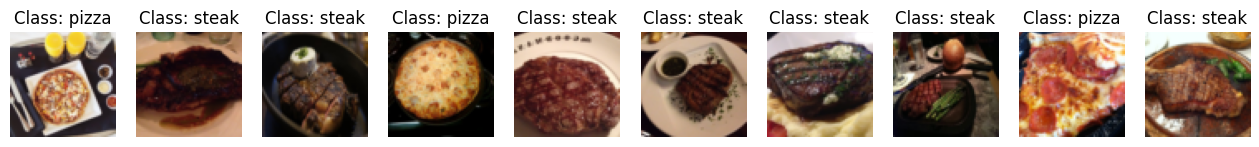

In [330]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed:int=None):
  if n > 10:
    n = 10
    display_shape = False
    print("For display purposes, n should not be larger than 10, setting to 10 and removing shape display!")
  if seed:
    random.seed(seed)

  # Get random samples
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16,8))

  # Loop and plot
  for i, targ_sample in enumerate(random_sample_idx):
    img, label = dataset[targ_sample][0], dataset[targ_sample][1]
    permuted_img = img.permute(1,2,0)
    plt.subplot(1,n,i+1)
    plt.imshow(permuted_img)
    if classes:
      title = f"Class: {classes[label]}"
      if display_shape:
        title += f"\nshape: {permuted_img.shape}"
    else:
      title= f"Class: {label}"
      if display_shape:
        title += f"\nshape: {permuted_img.shape}"
    plt.title(title)
    plt.axis(False)

display_random_images(train_data_custom, train_data_custom.classes, 12, False, seed=42)

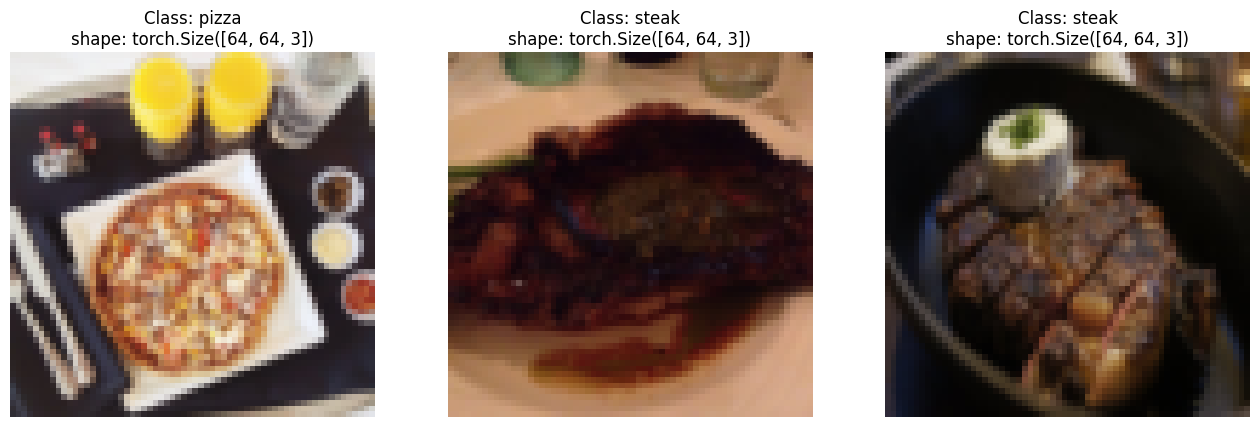

In [331]:
display_random_images(train_data_custom, train_data_custom.classes, 3, True, seed=42)

### 5.4 Turn custom dataset into dataloaders

In [332]:
import os
os.cpu_count()

2

In [333]:
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = 0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = 0,
                                     shuffle=False)

In [334]:
len(train_dataloader_custom), len(test_dataloader_custom)

(225, 75)

## 6. Other forms of transform - Data Augmentation


Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean appying various transforms to training images. - > Increases generalizability to unseen data

Let us look at one particular type of data augmention, used to train PyTorch vision models to state of the art levels...

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [335]:
# Let look at trivialaugment

train_transform = transforms.Compose([
    transforms.Resize(size=(224,244)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # 31 max intensity -> rotate max for e.g
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,244)),
    transforms.ToTensor()
])

In [336]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/steak/165639.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1413972.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2979061.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1264154.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2881783.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/225990.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2606444.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2017387.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3142045.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/3577618.jpg')]

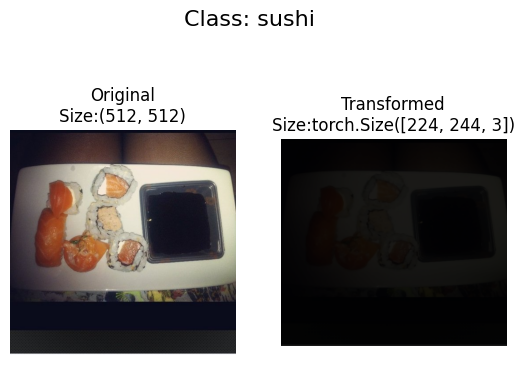

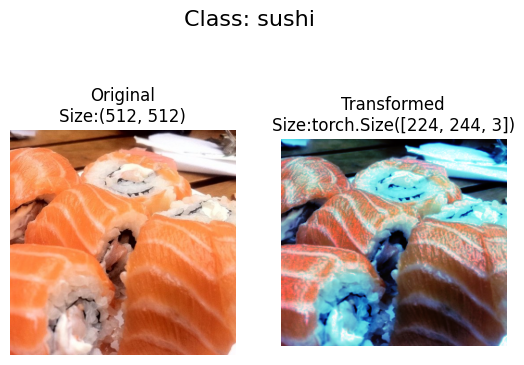

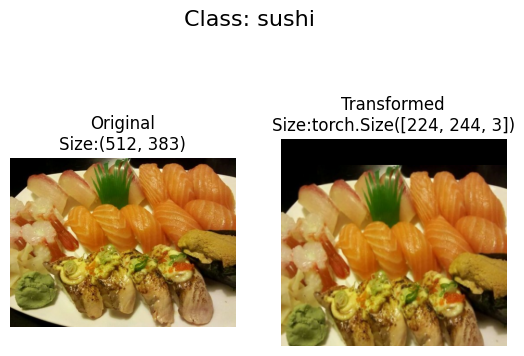

In [337]:
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n = 3,
    seed = None
)

## 7. Building Model 0 - Tiny VGG Architecture without Data Augmentation

### 7.1 Creating transforms and loading data for Model 0

In [338]:
# simple transform

simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])


In [339]:
# load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                 transform=simple_transform,
                                 target_transform=None)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                 transform=simple_transform,
                                 target_transform=None)

In [340]:
# turn into dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

In [341]:
# Building Model

class TinyVGG(nn.Module):
  """
  Model architecture that replicates the TinyVGG architecture.
  """
  def __init__(self, input_shape:int, output_shape:int, hidden_units:int) -> None:
    super().__init__() # initializer
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0), # values we can set -> hyperparamters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, # there is a trick to calculate this
                  out_features = output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f'Output shape of Conv block 1: {x.shape}')
    x = self.conv_block_2(x)
    # print(f'Output shape of Conv block 2: {x.shape}')
    x = self.classifier(x)
    # print(f'Output shape of classifier: {x.shape}')
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) #- > benefits from operator fusion


In [342]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, output_shape=len(class_names), hidden_units=10).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

#### Figuring out our answer -> for linear classifier layer!

In [343]:
random_A_tensor = torch.randn([32,3,64,64])
answer = model_0(random_A_tensor)
answer.shape

torch.Size([32, 3])

### Using torchinfo

In [344]:
!pip install torchinfo

In [345]:
import torchinfo
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64]) # input size should be correct!

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Train and test loop functions

In [346]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  # Put model into training mode
  model.train()
  train_loss, train_acc = 0,0
  for batch, (X,y) in enumerate(data_loader):
      X,y = X.to(device), y.to(device)
      y_pred = model(X) # forward pass
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() # total loss per batch
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # adjust train loss to get average training loss per batch, divide total train loss by len of train dataloader
  train_loss /= len(data_loader) #avg loss per epoch/ per batch
  train_acc /= len(data_loader)
  return train_loss, train_acc

In [347]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):
  """Performs a testing with model trying to learn on data_loader."""
  # Put model into training mode
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for batch, (X,y) in enumerate(data_loader):
        X,y = X.to(device), y.to(device)
        test_pred = model(X) # forward pass
        loss = loss_fn(test_pred, y)
        test_loss += loss.item()
        test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
        test_acc += (test_pred_class==y).sum().item()/len(test_pred)
    test_loss /= len(data_loader) #avg loss per epoch/ per batch
    test_acc /= len(data_loader)
    return test_loss, test_acc

In [348]:
from tqdm.auto import tqdm

In [349]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn : torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          num_epochs:int=5,
          device=device):
  results = {"train_loss" : [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)
    print(f"Epoch: {epoch+1} |\nTrain loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} |\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results


In [363]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model_0.parameters(), lr=0.001)

In [351]:
from timeit import default_timer as timer
start_time = timer()
results = train(model = model_0,
                train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                loss_fn = loss_fn,
                optimizer = optimizer,
                num_epochs = 5,
                device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |
Train loss: 1.1270 | Train Accuracy: 0.3333 |
Test Loss: 1.0958 | Test Accuracy: 0.3333
Epoch: 2 |
Train loss: 1.1038 | Train Accuracy: 0.3422 |
Test Loss: 1.1072 | Test Accuracy: 0.3333
Epoch: 3 |
Train loss: 1.1042 | Train Accuracy: 0.3289 |
Test Loss: 1.1057 | Test Accuracy: 0.3333
Epoch: 4 |
Train loss: 1.1036 | Train Accuracy: 0.3156 |
Test Loss: 1.0998 | Test Accuracy: 0.3333
Epoch: 5 |
Train loss: 1.1034 | Train Accuracy: 0.3333 |
Test Loss: 1.0932 | Test Accuracy: 0.4133
Total training time: 28.681 seconds


In [352]:
results

{'train_loss': [1.1269886936744054,
  1.1037896013259887,
  1.1042326789432102,
  1.10359346681171,
  1.1033634805679322],
 'train_acc': [0.3333333333333333,
  0.3422222222222222,
  0.3288888888888889,
  0.31555555555555553,
  0.3333333333333333],
 'test_loss': [1.0958110268910726,
  1.1072096729278564,
  1.105697250366211,
  1.099767541885376,
  1.0932355642318725],
 'test_acc': [0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.41333333333333333]}

### 7.8 Plot the loss curves of Model 0

A loss curve is a way of tracking your mode;'s progress over time.


In [353]:
results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [354]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary.
  Args:
    results (dict): dictionary."""
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out number of epochs

  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

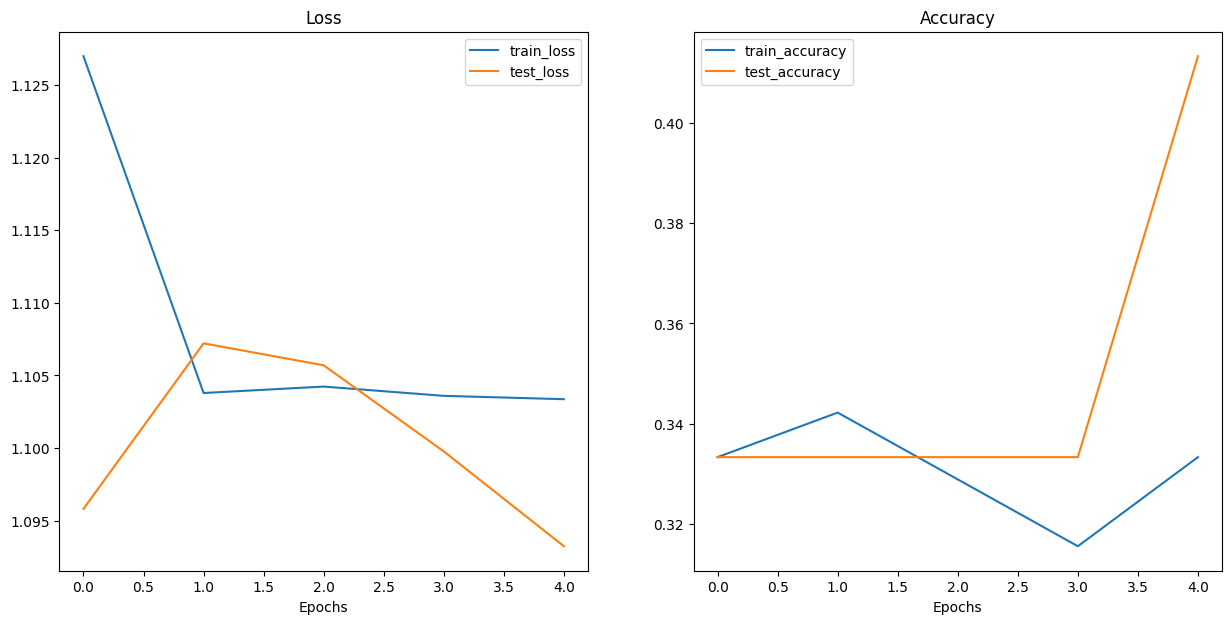

In [355]:
plot_loss_curves(results)

### 8. What should an ideal loss curve look like?

https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

### 9.1 Model 1 -> Using Data Augmentation


In [369]:
# Create data augmentation transform
# magnitude range 0 - 31
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # (also the default) 31 max intensity -> rotate max for e.g
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [370]:
train_data_trivial = datasets.ImageFolder(root=train_dir,
                                 transform=train_transform_trivial,
                                 target_transform=None)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform_simple,
                                 target_transform=None)

In [371]:
torch.manual_seed(42)

In [372]:
train_dataloader = DataLoader(dataset=train_data_trivial,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

In [373]:
model_1 = TinyVGG(input_shape=3, output_shape=len(class_names), hidden_units=10).to(device)

In [382]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_1.parameters(), lr=0.1)

In [384]:
start_time = timer()
model_1_results = train(model = model_1,
                train_dataloader = train_dataloader,
                test_dataloader = test_dataloader,
                loss_fn = loss_fn,
                optimizer = optimizer,
                num_epochs = 5,
                device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |
Train loss: 1.0923 | Train Accuracy: 0.4258 |
Test Loss: 1.1277 | Test Accuracy: 0.2604
Epoch: 2 |
Train loss: 1.1036 | Train Accuracy: 0.3047 |
Test Loss: 1.1357 | Test Accuracy: 0.2604
Epoch: 3 |
Train loss: 1.1123 | Train Accuracy: 0.3047 |
Test Loss: 1.1077 | Test Accuracy: 0.2604
Epoch: 4 |
Train loss: 1.0986 | Train Accuracy: 0.3047 |
Test Loss: 1.1223 | Test Accuracy: 0.1979
Epoch: 5 |
Train loss: 1.1068 | Train Accuracy: 0.2930 |
Test Loss: 1.0975 | Test Accuracy: 0.1979
Total training time: 11.646 seconds


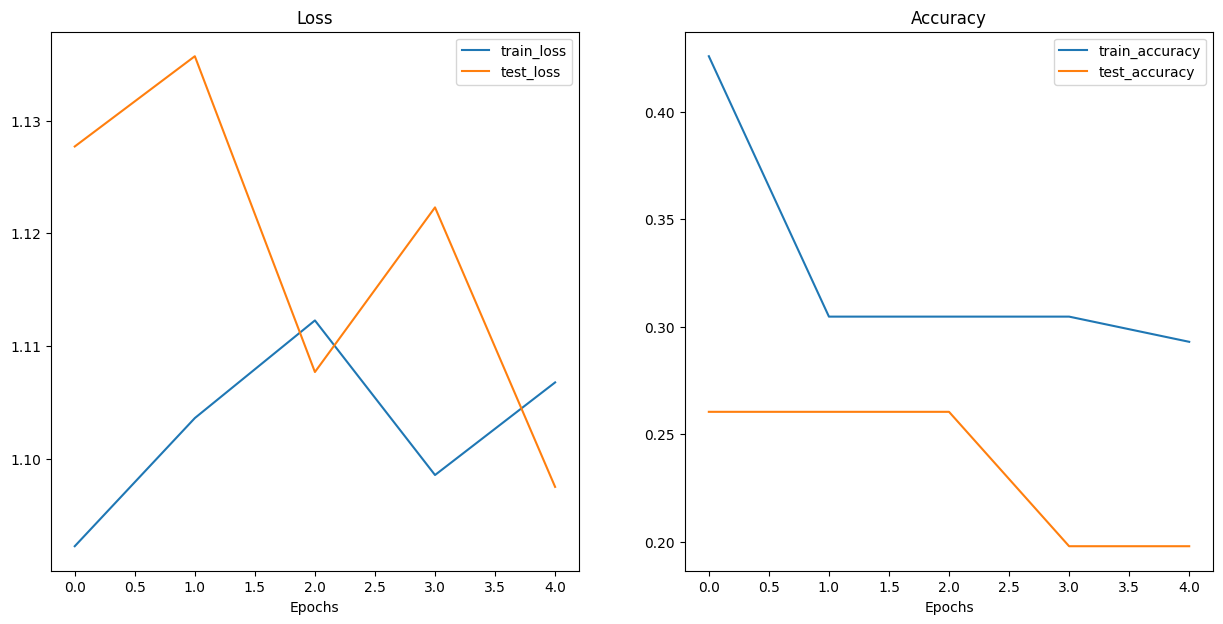

In [385]:
plot_loss_curves(model_1_results)

### 10. Compare model results

1. Manual code
2. PyTorch + Tensorboard
3. Weights + biases

In [386]:
import pandas as pd
model_0_df = pd.DataFrame(results)
model_1_df = pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.092272,0.425781,1.127697,0.260417
1,1.103628,0.304688,1.135697,0.260417
2,1.112281,0.304688,1.107710,0.260417
3,1.098582,0.304688,1.122301,0.197917
4,1.106789,0.292969,1.097529,0.197917


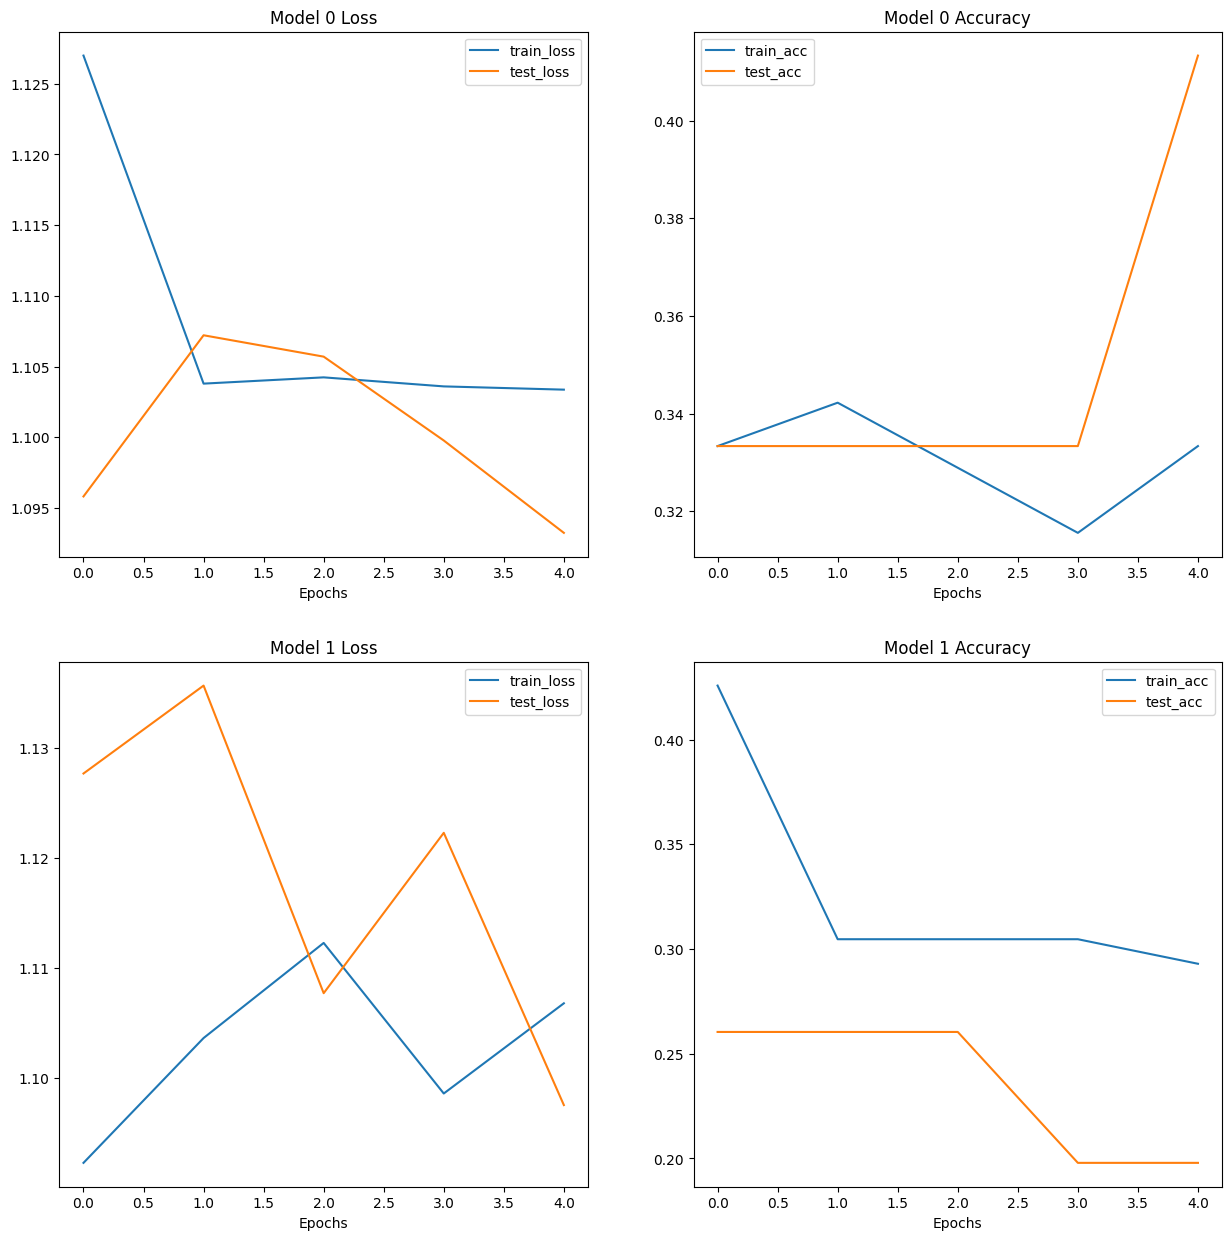

In [388]:
# Set up a plot
plt.figure(figsize=(15,15))
epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(
    epochs,
    model_0_df["train_loss"],
    label="train_loss"
)
plt.plot(
    epochs,
    model_0_df["test_loss"],
    label="test_loss"
)
plt.title("Model 0 Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,2)
plt.plot(
    epochs,
    model_0_df["train_acc"],
    label="train_acc"
)
plt.plot(
    epochs,
    model_0_df["test_acc"],
    label="test_acc"
)
plt.title("Model 0 Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,3)
plt.plot(
    epochs,
    model_1_df["train_loss"],
    label="train_loss"
)
plt.plot(
    epochs,
    model_1_df["test_loss"],
    label="test_loss"
)
plt.title("Model 1 Loss")
plt.xlabel("Epochs")
plt.legend()
plt.subplot(2,2,4)
plt.plot(
    epochs,
    model_1_df["train_acc"],
    label="train_acc"
)
plt.plot(
    epochs,
    model_1_df["test_acc"],
    label="test_acc"
)
plt.title("Model 1 Accuracy")
plt.xlabel("Epochs")
plt.legend()


## 11. Making a prediction on a custom image

How to predict on a image not a part of test data?

In [499]:
# Download a custom image
import requests
custom_image_path = data_path/ "04-pizza-dad.jpeg"

with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    f.write(request.content)


In [500]:
custom_image_path = str(custom_image_path)

In [501]:
custom_image_path

'data/04-pizza-dad.jpeg'

### 11. 1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

- tensor format
- size match

Use the `read image`

In [502]:
import torchvision

custom_image_unit8 = torchvision.io.read_image(custom_image_path)

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

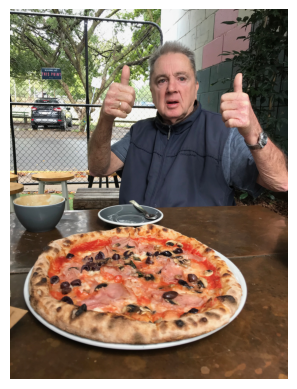

In [503]:
plt.imshow(custom_image_unit8.permute(1,2,0))
plt.axis(False)

In [504]:
custom_image_unit8.shape

torch.Size([3, 4032, 3024])

In [505]:
custom_image_unit8.dtype # need to change it to float32

torch.uint8

In [506]:
# Try to make a prediction on an image in unit8 format

model_1.eval()
with torch.inference_mode():
  model_1(custom_image_unit8.to(device)) # dtype error

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [507]:
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32)

In [508]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device)) # shape mismatch error

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [509]:
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32)/255

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

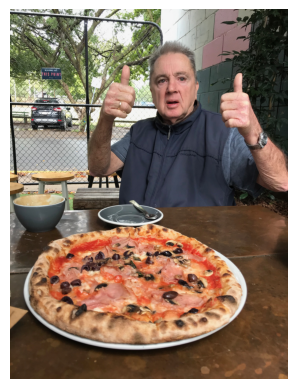

In [510]:
plt.imshow(custom_image.permute(1,2,0))
plt.axis(False)



In [511]:
# Create a transform pipeline to resize !

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
])
custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

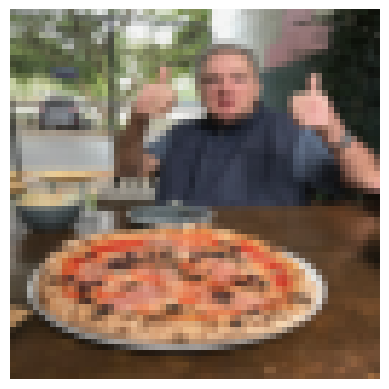

In [512]:
plt.imshow(custom_image_transformed.permute(1,2,0))
plt.axis(False)

In [513]:
 # error - not on right device
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [514]:
# need batch dimension - still error
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [515]:
custom_image_transformed = custom_image_transformed.unsqueeze(0)

In [516]:
custom_image_transformed.shape

torch.Size([1, 3, 64, 64])

In [517]:
# need batch dimension - still error
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed).to(device)
custom_image_pred

tensor([[-0.0580, -0.0159, -0.0247]])

Note, to make a prediction on a custom image, we had to:

1. Load the image and turn it into a tensor
2. Should be on the same device
3. Same datatype (not unit8)
4. Compatible device

In [518]:
# Convert logits to prediction probs -> to pred labels
# need batch dimension - still error
custom_image_pred_prob = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_label = torch.argmax(custom_image_pred_prob, dim=1)
custom_image_pred_prob, custom_image_pred_label

(tensor([[0.3250, 0.3390, 0.3360]]), tensor([1]))

In [519]:
class_names[custom_image_pred_label]

'steak'

### 11.3 Putting custom image prediction together!

In [525]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  """Makes a prediction on a target image using a trained model and plots the image and prediction."""
  # load image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # divide pixels by 255 to get values between [0,1]
  target_image = target_image / 255

  if transform:
    target_image = transform(target_image)

  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)
    target_image_pred  = model(target_image.to(device))

  # convert to pred probs -> labels
  target_image_pred_prob = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_prob, dim=1)

  # plot the image and prediction
  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title = f'Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_prob.max().cpu():.3f}'
  else:
    title = f'Pred: {target_image_pred_label.cpu()}| Prob: {target_image_pred_prob.max().cpu():.3f}'
  plt.title(title)
  plt.axis(False)

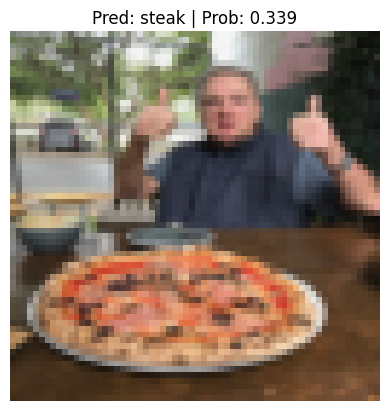

In [528]:
pred_and_plot_image(model=model_1,
                    image_path='data/04-pizza-dad.jpeg',
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)